<a href="https://colab.research.google.com/github/muthiearml/MachineLearning/blob/main/Week12/(Lecture12)CNN_GermanTrafficSign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Muthie Armalia S
#### 1103200178


In [1]:
#Install modul kaggle
!pip install kaggle

In [2]:
from google.colab import files

# Upload file kaggle.json
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"muthiearmalias","key":"c8aa4051770e2bca69229eaaa6bcdf0c"}'}

In [3]:
# Membuat direktori Kaggle
!mkdir -p ~/.kaggle

# Pindahkan file kaggle.json ke direktori Kaggle
!mv kaggle.json ~/.kaggle/

In [4]:
# Mencari dataset yang tersedia di kaggle
!kaggle datasets list -s "German Traffic Sign Dataset"

ref                                                                title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
harbhajansingh21/german-traffic-sign-dataset                       German Traffic Sign Dataset                        118MB  2023-07-11 04:21:24            469         29  1.0              
valentynsichkar/traffic-signs-preprocessed                         Traffic Signs Preprocessed                           4GB  2019-08-31 18:22:11          12894        277  1.0              
valentynsichkar/traffic-signs-dataset-in-yolo-format               Traffic Signs Dataset in YOLO format               250MB  2020-04-03 22:25:16          13915        119  0.9375           
eunjurho/german-traffic-sign-recognition-benchmark

In [5]:
# Download dan ekstrak dataset, dimana nantinya akan satu direktori dengan notebook ini
!kaggle datasets download harbhajansingh21/german-traffic-sign-dataset --unzip

 98% 116M/118M [00:07<00:00, 25.6MB/s]
100% 118M/118M [00:07<00:00, 16.6MB/s]


## CNN

In [6]:
# Mengimpor library
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPool2D
from sklearn.model_selection import train_test_split
import pickle
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

In [7]:
# Load dataset dengan pickle
training_file = "/content/train.p"
testing_file = "/content/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)

with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

print("Data loaded")

Data loaded


In [8]:
# Load CSV file
sign_name_df = pd.read_csv('/content/signname.csv')
SIGN_NAMES = sign_name_df.SignName.values
sign_name_df.set_index('ClassId', inplace=True)
sign_name_df.head(10)

,SignName
ClassId,
0,Speed limit (20km/h)
1,Speed limit (30km/h)
2,Speed limit (50km/h)
3,Speed limit (60km/h)
4,Speed limit (70km/h)
5,Speed limit (80km/h)
6,End of speed limit (80km/h)
7,Speed limit (100km/h)
8,Speed limit (120km/h)


In [9]:
# Displaying Data
matplotlib.style.use('ggplot')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [10]:
# Define features and labels for training data
X, y = train['features'], train['labels']

# Converting lists into numpy arrays
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

# Define the features and labels for testing data
X_test, y_test = test['features'], test['labels']

# Converting lists into numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(34799, 32, 32, 3) (34799,)
(12630, 32, 32, 3) (12630,)


In [11]:
X, y = train['features'], train['labels']

In [12]:
data = np.array(X)
labels = np.array(y)
print(data.shape, labels.shape)

(34799, 32, 32, 3) (34799,)


In [13]:
X_test, y_test = test['features'], test['labels']

In [14]:
X_test = np.array(X_test)
y_test = np.array(y_test)
print(X_test.shape, y_test.shape)

(12630, 32, 32, 3) (12630,)


In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(31319, 32, 32, 3) (3480, 32, 32, 3) (31319,) (3480,)


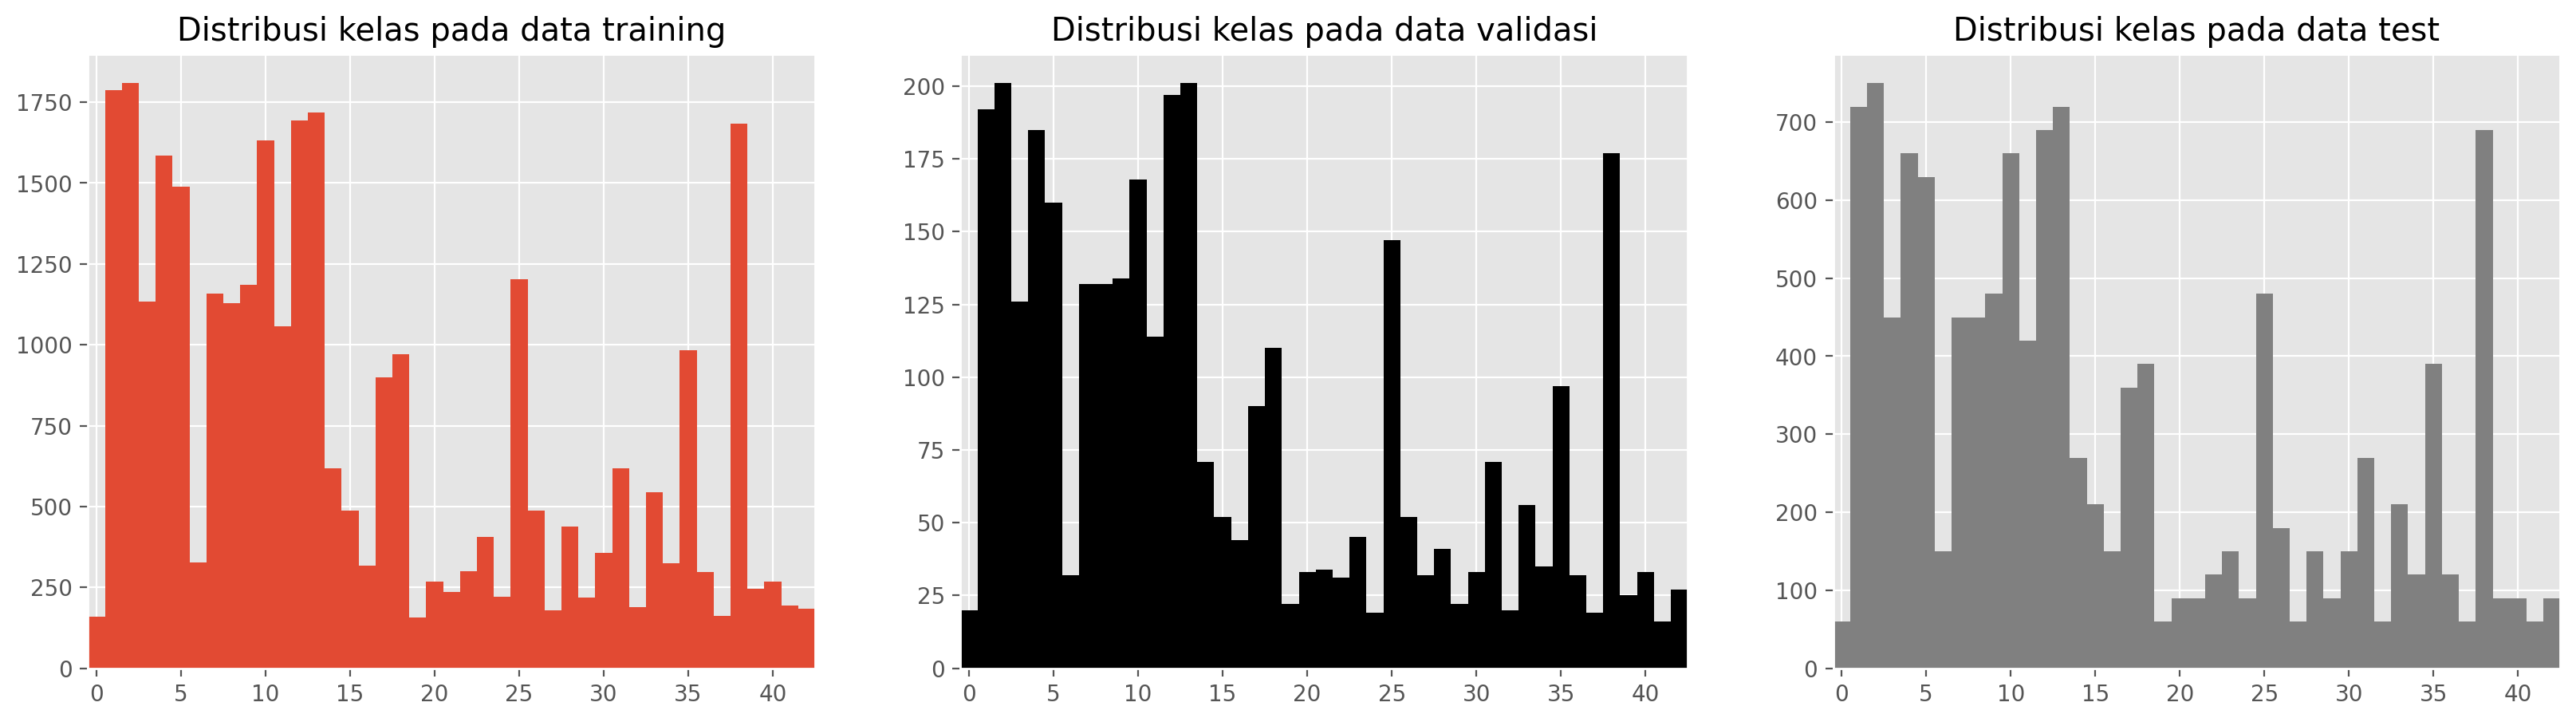

In [16]:
n_labels = np.unique(y_train).size

def hist_data(y_data, title=None, ax=None, **kwargs):
    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.hist(y_data, np.arange(-0.5, n_labels+1.5), stacked=True, **kwargs)
    ax.set_xlim(-0.5, n_labels-0.5)
    if 'label' in kwargs:
        ax.legend()
    if title:
        ax.set_title(title)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
hist_data(y_train, title='Distribusi kelas pada data training', ax=ax[0])
hist_data(y_val, title='Distribusi kelas pada data validasi', ax=ax[1], color='black')
hist_data(y_test, title='Distribusi kelas pada data test', ax=ax[2], color='grey')

In [17]:
# Converting Labels into One-Hot Encoding
from tensorflow.keras.utils import to_categorical
y_train = to_categorical (y_train,43)
y_val = to_categorical(y_val,43)

In [18]:
# callback for Early Stopping
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') > 0.96):
            print("\nAkurasi telah mencapai >96%. Stop training!")
            self.model.stop_training = True
callbacks = myCallback()

In [19]:
# Define the CNN model
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_train.shape[1:]))
model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(43, activation='softmax'))

In [21]:
# Print Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        2432      
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 12, 12, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 12, 12, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          36928     
                                                        

In [22]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
epochs = 25
history = model.fit(X_train, y_train, batch_size=32, epochs=epochs, validation_data=(X_val, y_val), callbacks=[callbacks])

Epoch 1/25
979/979 [==============================] - 129s 132ms/step - loss: 0.3404 - accuracy: 0.8958 - val_loss: 0.1187 - val_accuracy: 0.9649
Epoch 2/25
979/979 [==============================] - 130s 133ms/step - loss: 0.3010 - accuracy: 0.9100 - val_loss: 0.0912 - val_accuracy: 0.9730
Epoch 3/25
979/979 [==============================] - 132s 134ms/step - loss: 0.2582 - accuracy: 0.9210 - val_loss: 0.1034 - val_accuracy: 0.9718
Epoch 4/25
979/979 [==============================] - 135s 138ms/step - loss: 0.2520 - accuracy: 0.9234 - val_loss: 0.0804 - val_accuracy: 0.9739
Epoch 5/25
979/979 [==============================] - 130s 133ms/step - loss: 0.2449 - accuracy: 0.9274 - val_loss: 0.0702 - val_accuracy: 0.9807
Epoch 6/25
979/979 [==============================] - 133s 135ms/step - loss: 0.2220 - accuracy: 0.9347 - val_loss: 0.0966 - val_accuracy: 0.9750
Epoch 7/25
979/979 [==============================] - 131s 134ms/step - loss: 0.2363 - accuracy: 0.9309 - val_loss: 0.0702 -

In [25]:
model.save("my_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


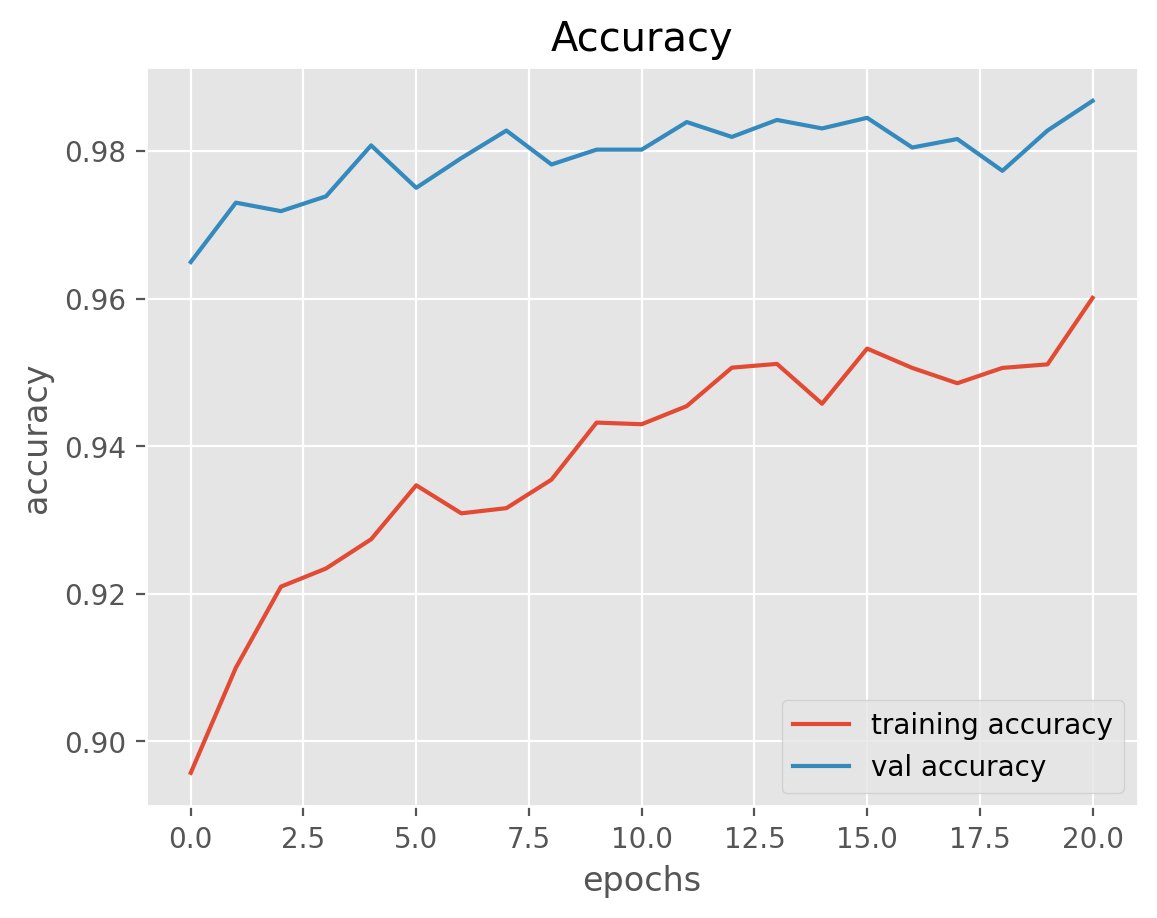

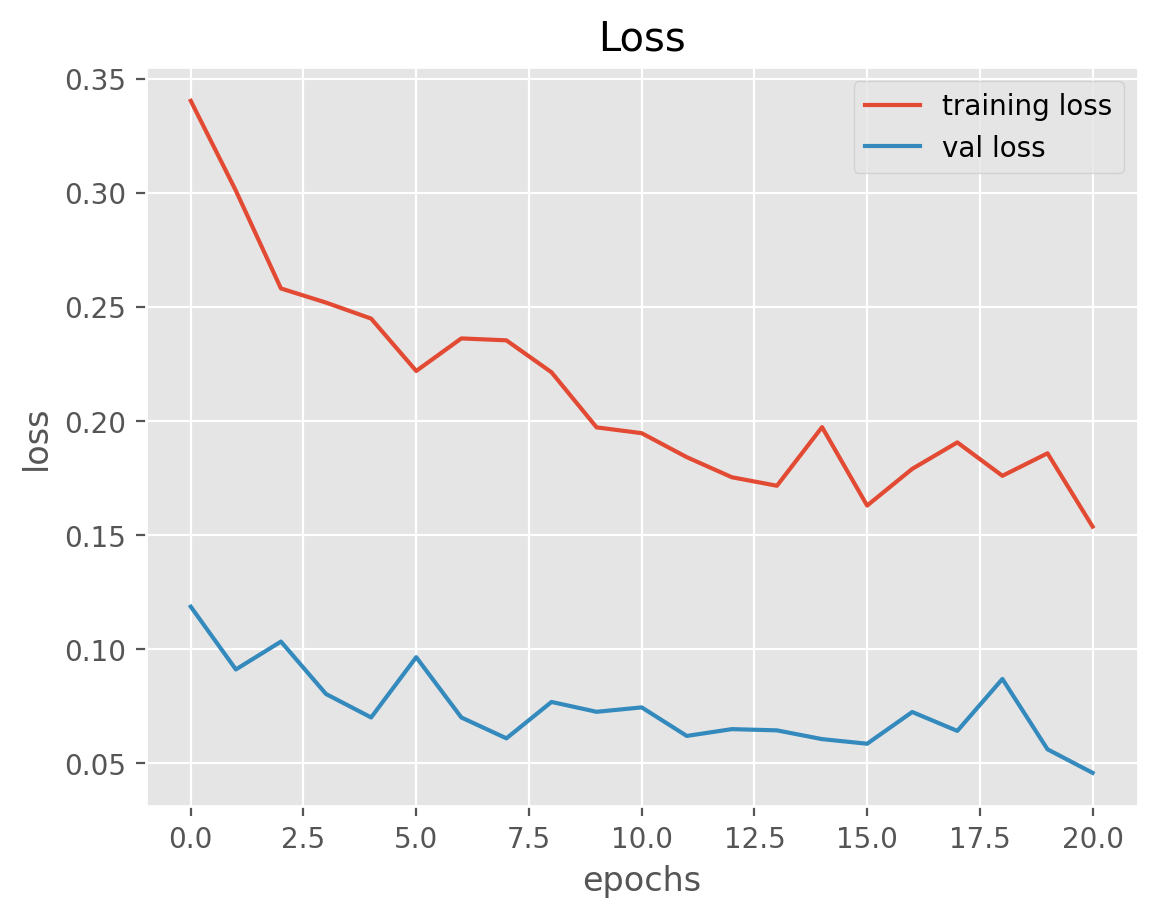

In [26]:
# Plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

# Plotting graphs for loss
plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [27]:
from sklearn.metrics import accuracy_score

pred = np.argmax(model.predict(X_test), axis=-1)
accuracy_score(y_test, pred)

395/395 [==============================] - 14s 36ms/step


0.9460807600950119

In [28]:
from sklearn.metrics import classification_report

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96        60
           1       0.96      0.97      0.96       720
           2       0.88      1.00      0.93       750
           3       0.98      0.88      0.92       450
           4       0.99      0.97      0.98       660
           5       0.88      0.93      0.90       630
           6       0.99      0.74      0.85       150
           7       1.00      0.98      0.99       450
           8       0.98      0.94      0.96       450
           9       0.95      0.99      0.97       480
          10       0.97      0.99      0.98       660
          11       0.94      0.97      0.96       420
          12       0.97      0.97      0.97       690
          13       0.98      0.99      0.99       720
          14       1.00      0.99      0.99       270
          15       0.90      0.96      0.93       210
          16       0.99      0.99      0.99       150
          17       1.00    